In [1]:
import logging
import pandas as pd
from prometheus_client import CollectorRegistry, Gauge, push_to_gateway
from sklearn.ensemble import IsolationForest
import requests
import configparser

In [10]:
config = configparser.ConfigParser()
config.read('../config/config.ini')

PROMETHEUS_GATEWAY = config['Prometheus']['PushGateway']
PROMETHEUS_API = config['Prometheus']['API']
LOG_FILE = '../data/logs/analysis.log'

# Configure logging
logging.basicConfig(
    filename=LOG_FILE,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [47]:
metric_name = 'numenta_cpu_aws'
response = requests.get(f"{PROMETHEUS_API}/api/v1/query_range", params={"query": 'numenta_cpu_aws{instance="cloudwatch_benchmark"}', "start":"1754604140", "end":"1755814940", "step":"300.0"})
response.raise_for_status()
results = response.json()['data']['result']

In [48]:
results

[{'metric': {'__name__': 'numenta_cpu_aws',
   'instance': 'cloudwatch_benchmark',
   'job': 'numenta_import'},
  'values': [[1754604140, '42.652'],
   [1754604440, '41.362'],
   [1754604740, '43.408'],
   [1754605040, '40.262'],
   [1754605340, '40.328'],
   [1754605640, '42.652'],
   [1754605940, '39.836'],
   [1754606240, '42.57'],
   [1754606540, '45.212'],
   [1754606840, '41.15'],
   [1754607140, '42.91'],
   [1754607440, '43.756'],
   [1754607740, '38.522'],
   [1754608040, '42.488'],
   [1754608340, '41.268'],
   [1754608640, '42.136'],
   [1754608940, '42.066'],
   [1754609240, '43.544'],
   [1754609540, '38.404'],
   [1754609840, '42.018'],
   [1754610140, '44.872'],
   [1754610440, '40.658'],
   [1754610740, '42.276'],
   [1754611040, '43.052'],
   [1754611340, '43.56800000000001'],
   [1754611640, '38.356'],
   [1754611940, '39.788'],
   [1754612240, '41.83'],
   [1754612540, '39.038'],
   [1754612840, '42.184'],
   [1754613140, '41.76'],
   [1754613440, '43.99'],
   [17546

In [49]:
data = []
for result in results:
    if 'values' in result:
        for value in result['values']:
            data.append({"timestamp": value[0], "value": float(value[1])})

if not data:
    logging.error("No valid data found for metric: %s", metric_name)
    raise ValueError("No data available for the specified metric.")

df = pd.DataFrame(data)

<Axes: >

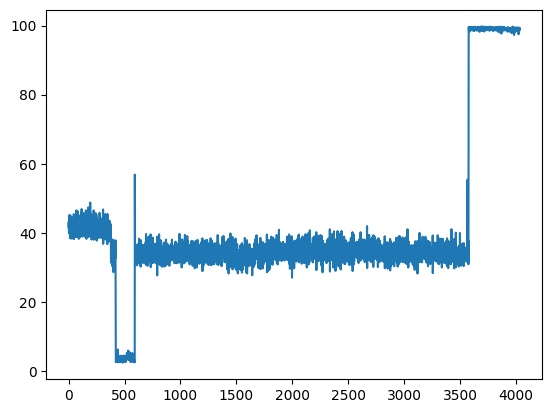

In [52]:
df["value"].plot()

In [26]:
from prometheus_remote_writer import RemoteWriter
writer = RemoteWriter(
            url="http://prometheus:9090/api/v1/write",
            # headers={"Content-Encoding": "snappy"}
            
        )

In [27]:
# Prepare the data to send
data = [
    {
        'metric': {'__name__': 'dummy_cpu', 'host': 'server1'},
        'values': [23.5, 24.1, 22.8],
        'timestamps': [1609459200000, 1609459260000, 1609459320000]
    }
]

# Send the data
writer.send(data)

RuntimeError: Failed to send data to http://prometheus:9090/api/v1/write: HTTPConnectionPool(host='prometheus', port=9090): Max retries exceeded with url: /api/v1/write (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x000002998500B350>: Failed to resolve 'prometheus' ([Errno 11001] getaddrinfo failed)"))

In [32]:
import pandas as pd
from datetime import datetime
# --- Configuration ---
csv_file_path = r'C:\Users\admin\Documents\VP\Week 7-8\aiops_platform_project\project1-aiops\data\nab\realAWSCloudwatch\ec2_cpu_utilization_ac20cd.csv'
output_file_path = 'metrics.om'
metric_name = 'numenta_cpu_utilization'
# Add any labels you want to associate with the metric
labels = {'job': 'numenta_import', 'instance': 'cloudwatch_benchmark'}

# --- Script Logic ---
print(f"Reading data from '{csv_file_path}'...")
try:
    # Read the CSV file
    df = pd.read_csv(csv_file_path)
    # Convert timestamp column to datetime objects
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    current_year = datetime.now().year
    df['timestamp'] = df['timestamp'].apply(lambda x: x.replace(year=current_year))

except FileNotFoundError:
    print(f"Error: The file '{csv_file_path}' was not found.")
    exit()

# Create the label string for OpenMetrics format
label_str = "{" + ",".join([f'{k}="{v}"' for k, v in labels.items()]) + "}"

print(f"Converting data to OpenMetrics format...")
with open(output_file_path, 'w') as f:
    for index, row in df.iterrows():
        # Convert timestamp to Unix timestamp in milliseconds
        timestamp_ms = int(row['timestamp'].timestamp() * 1000)
        value = row['value']

        # Write the formatted line to the output file
        f.write(f"{metric_name}{label_str} {value} {timestamp_ms}\n")

    # Add the # EOF to signify the end of the file
    f.write("# EOF\n")

print(f"✅ Successfully created OpenMetrics file at '{output_file_path}'")  # Example file path

Reading data from 'C:\Users\admin\Documents\VP\Week 7-8\aiops_platform_project\project1-aiops\data\nab\realAWSCloudwatch\ec2_cpu_utilization_ac20cd.csv'...
Converting data to OpenMetrics format...
✅ Successfully created OpenMetrics file at 'metrics.om'
